In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit.quantum_info import partial_trace, Statevector

from numpy import pi
from qiskit.circuit.library import GroverOperator, ZGate

In [2]:
# a >= b

def greaterThanEqual(qc, a, b, aux, output, n):
        
    # Check most significant bit

    # Check that a[n-1] is 1 and b[n-1] is 0
    qc.x(b[n-1])
    qc.ccx(a[n-1], b[n-1], output[0])
    
    # Check if both a[n-1] and b[n-1] are 0 
    qc.x(a[n-1])
    qc.ccx(a[n-1], b[n-1], aux[n-1])
    
    # Check if both a[n-1] and b[n-1] are 1
    qc.x(a[n-1])
    qc.x(b[n-1])
    qc.ccx(a[n-1], b[n-1], aux[n-1])
    
    # Check the rest of the bits
    for i in range(n-2, -1, -1):
        # Check that a[i] is 1 and b[i] is 0 if the previous bits were equal
        qc.x(b[i])
        qc.mct([a[i], b[i], aux[i+1]], output[0])
    
        # Check if both a[i] and b[i] are 0 
        qc.x(a[i])
        qc.mct([a[i], b[i], aux[i+1]], aux[i])
    
        # Check if both a[i] and b[i] are 1
        qc.x(a[i])
        qc.x(b[i])
        qc.mct([a[i], b[i], aux[i+1]], aux[i])
        
    # Returning 1 if both numbers are equal
    qc.cx(aux[0], output[0])
    
    # Reversing circuit to put aux back to original state
    for i in range(0, n-1):
    
        # Check if both a[i] and b[i] are 0
        qc.x(b[i])
        qc.x(a[i])
        qc.mct([a[i], b[i], aux[i+1]], aux[i])
    
        # Check if both a[i] and b[i] are 1
        qc.x(a[i])
        qc.x(b[i])
        qc.mct([a[i], b[i], aux[i+1]], aux[i])
        
    qc.x(b[n-1])
    qc.x(a[n-1])
    qc.ccx(a[n-1], b[n-1], aux[n-1])
    
    # Check if both a[n-1] and b[n-1] are 1
    qc.x(a[n-1])
    qc.x(b[n-1])
    qc.ccx(a[n-1], b[n-1], aux[n-1])
    
def initilizeQubits(qc, b, regB, n):
    for i in range(n):
        if (b[i] == "1"):
            qc.x(regB[n-(i+1)])
            
def comparisonOracle(qc, a, b, aux0, aux1, output, n):
    # Compute
    greaterThanEqual(qc, a, b, aux0, aux1, n)
    
    qc.cx(aux1, output)
    
    # Uncompute
    greaterThanEqual(qc, a, b, aux0, aux1, n)
    
def diffuser(qc, a,nqubits):
#     qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(a[qubit])
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(a[qubit])
    # Do multi-controlled-Z gate
    qc.h(a[nqubits-1])
    qc.mct([a[i] for i in range(nqubits-1)], a[nqubits-1])  # multi-controlled-toffoli
    qc.h(a[nqubits-1])
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(a[qubit])
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(a[qubit])
    # We will return the diffuser as a gate
    
# def diffuser(qc, a, b,nqubits):
# #     qc = QuantumCircuit(nqubits)
#     # Apply transformation |s> -> |00..0> (H-gates)
#     for qubit in range(nqubits):
#         qc.h(b[qubit])
#         qc.h(a[qubit])
#     # Apply transformation |00..0> -> |11..1> (X-gates)
#     for qubit in range(nqubits):
#         qc.x(a[qubit])
#         qc.x(b[qubit])
#     # Do multi-controlled-Z gate
#     qc.h(a[nqubits-1])
#     qc.mct([a[i] for i in range(nqubits-1)] + [b[i] for i in range(nqubits-1)], a[nqubits-1])  # multi-controlled-toffoli
#     qc.h(a[nqubits-1])
#     # Apply transformation |11..1> -> |00..0>
#     for qubit in range(nqubits):
#         qc.x(a[qubit])
#         qc.x(b[qubit])
#     # Apply transformation |00..0> -> |s>
#     for qubit in range(nqubits):
#         qc.h(a[qubit])
#         qc.h(b[qubit])
#     # We will return the diffuser as a gate

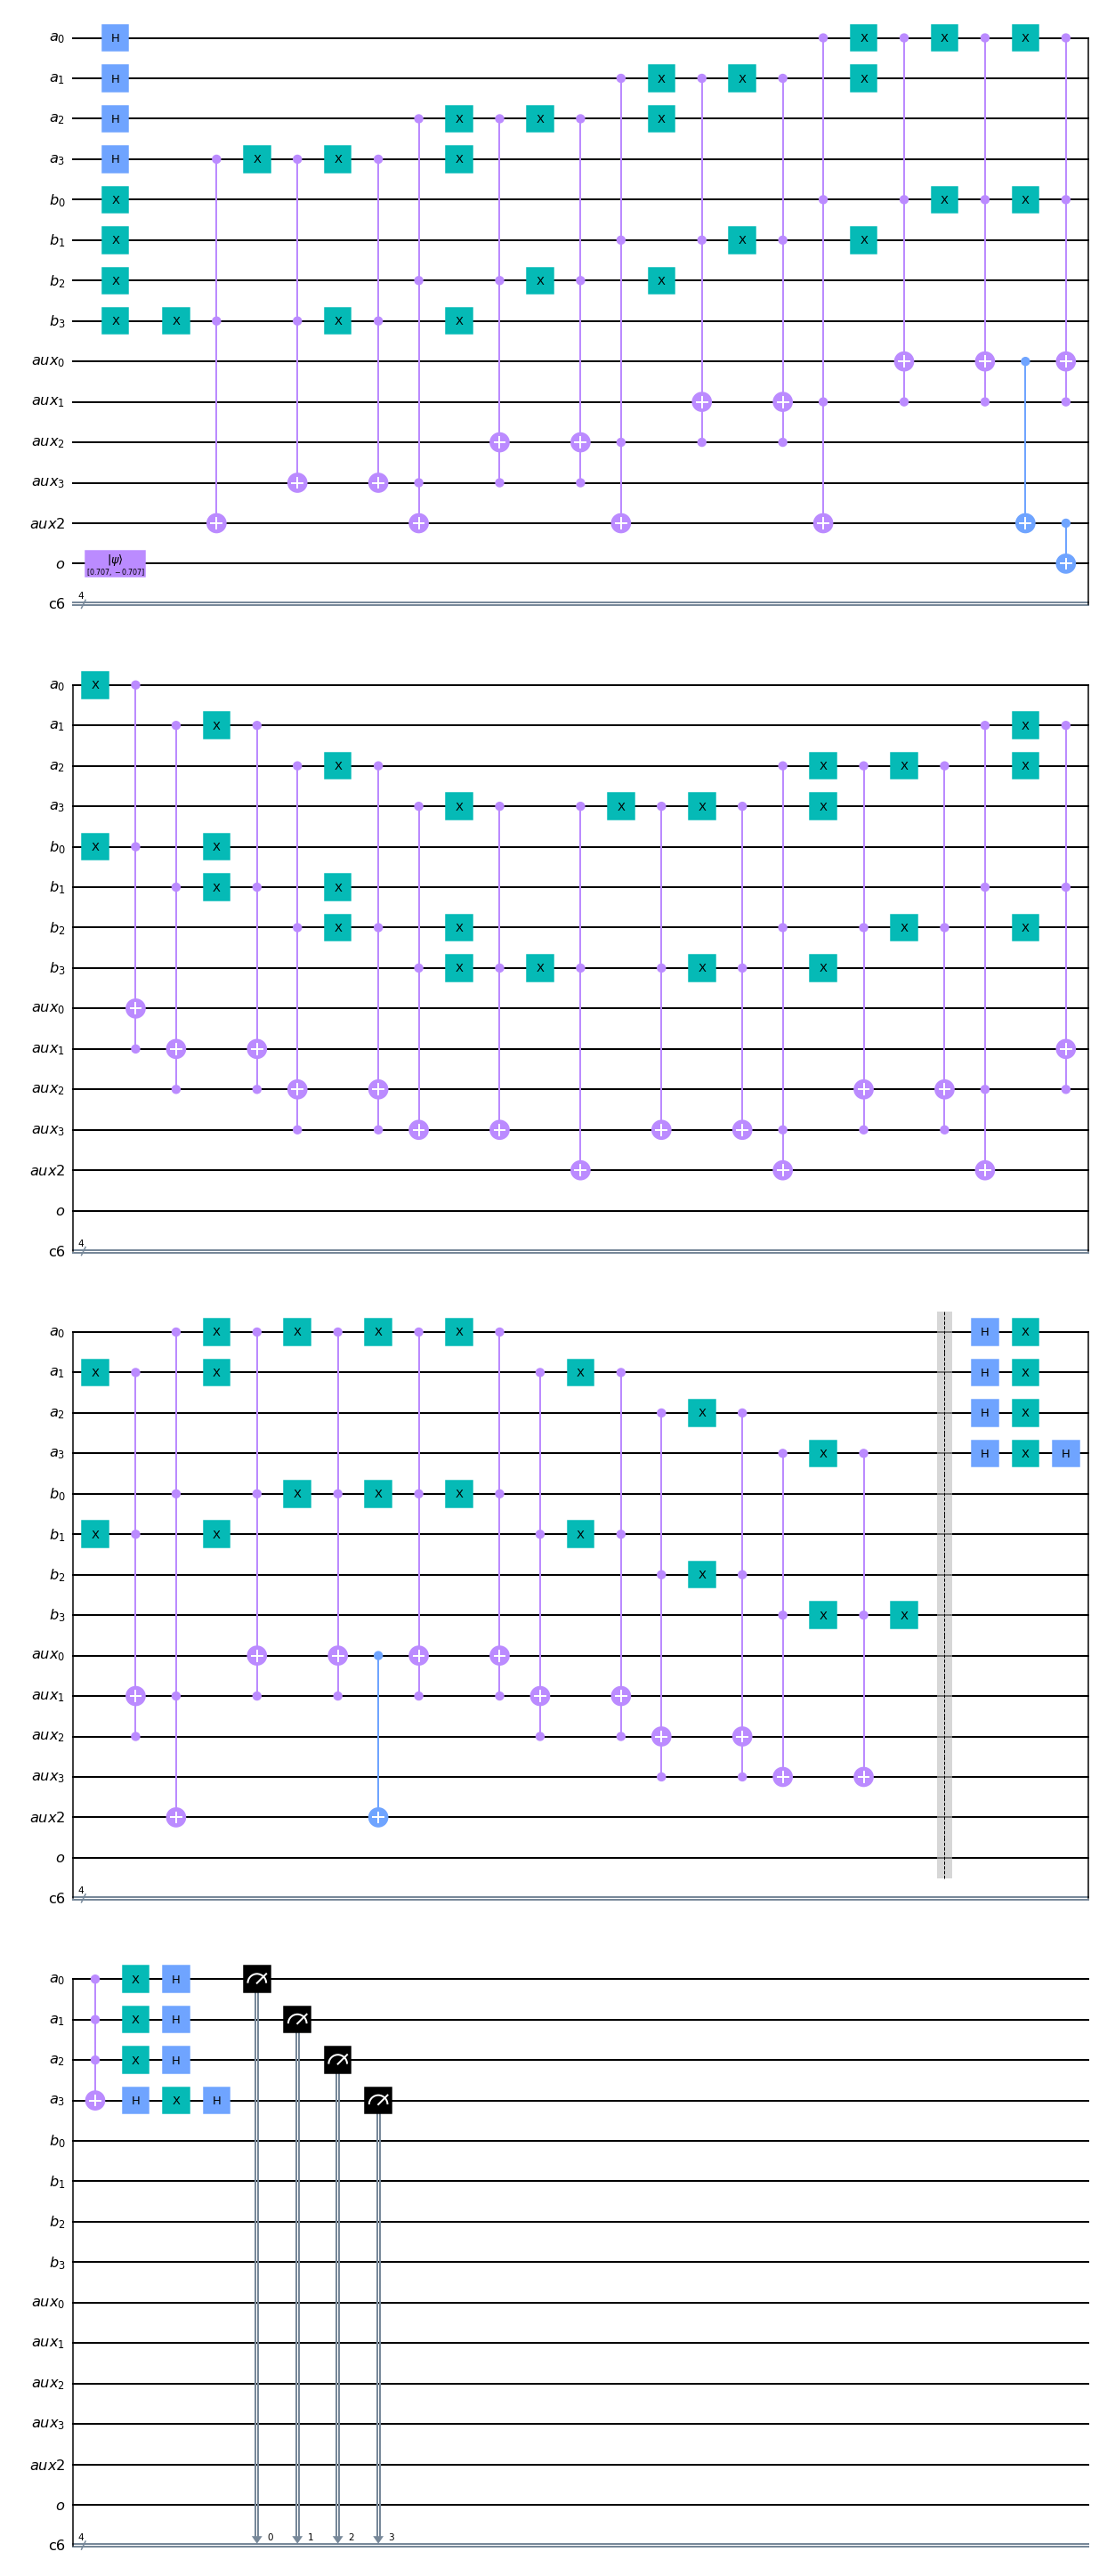

In [11]:
a = "01"
b = "1000"

n = 4
regA = QuantumRegister(n, name="a")
regB = QuantumRegister(n, name="b")
regAux = QuantumRegister(n, name="aux")
regAux2 = QuantumRegister(1, name="aux2")
regO = QuantumRegister(1, name="o")

output = ClassicalRegister(n)

qc = QuantumCircuit(regA, regB, regAux, regAux2, output, regO)

# Turning output to state |->
qc.initialize([1, -1]/np.sqrt(2), regO)
# qc.x(regO)
# qc.h(regO)
initilizeQubits(qc, b, regB, n)
qc.h(regA)
comparisonOracle(qc, regA, regB, regAux, regAux2, regO, n)
initilizeQubits(qc, b, regB, n)
qc.barrier()
# comparisonOracle(qc, regA, regB, regAux, regAux2, regO, n)
# qc.barrier()
diffuser(qc, regA, n)
# qc.append(diffuser(n), regA)
# qc.measure(regA, output)
# qc.measure_all()
qc.draw('mpl')

In [ ]:
# Measure
aer_sim = Aer.get_backend('aer_simulator')
# transpiled_grover_circuit = transpile(qc, aer_sim)
# transpiled_grover_circuit.save_statevector()
qc.save_statevector()
qobj = assemble(qc)
result = aer_sim.run(qobj).result()
statevec = result.get_statevector()
# partial_density_matrix = partial_trace(statevec, [1, 2])

# extract the statevector out of the density matrix
# partial_statevector = np.diagonal(partial_density_matrix)
# print(partial_statevector)
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

In [ ]:
pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

In [12]:
# Measure
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(qc, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
print(counts)

{'0111': 55, '0000': 68, '1000': 61, '1011': 67, '1101': 62, '1110': 66, '0101': 64, '1010': 64, '0001': 59, '0110': 67, '1100': 69, '1111': 72, '0011': 66, '0100': 59, '0010': 64, '1001': 61}


In [ ]:
grover_op = GroverOperator(qc, insert_barriers=True, reflection_qubits = [regA[i] for i in range(n)])
grover_op.decompose().draw(output='mpl')

In [ ]:
"""
Oracle 1 Circuit

Computes the square of the inner product of two row vectors of length k
Works with signed numbers
Brings the state |f>|d>|0> -> |f>|d>|(d.f)^2>

Qubits [0 : n*k] are for the row vector f
Qubits [n*k : 2*n*k] are for the row vector d
Qubits [2*n*k : 2*n*k + 4*n] are for carry bits
Qubits [2*n*k + 4*n : 2*n*k + 8*n] are for ancilla bits
Qubits [2*n*k + 8*n : 4*n*k + 8*n] are for the output registers
Qubits [4*n*k + 8*n : 4*n*k + 8*n + 2] are for control qubits
Qubits [4*n*k + 8*n + 2 : 4*n*k + 12*n + 2] are for the final output

Total Qubits required = 4*n*k + 12*n + 2

Paramters: n

"""

"""
Load operation - Creates a superposition of all rows of a matrix

Takes the state |i>|0> --> |i>|fi> where fi is a row vectors of a matrix F

Puts the result into a superposition of all possible vector rows from F, where observing
|i> and |fi> will give you the row vectors fi .

Qubits [0 : iLength] hold the register for |i>
Qubits [iLength : 2*iLength] are ancilla bits for holding the NOT of |i>
Qubits [2*iLength : 2*iLength+(k*n)] hold the result vector |fi> and should initially be 0
Qubits [2*iLength + (k*n) : 2*iLength + n*k + n*k*2^iLength] hold the database for the matrix f
    
Parameters: iLength : Length of the register |i>
            n : Length of one element of the database
            k : Number of elements in a row of the database
            
Total qubits = 2*iLength + n*k + n*k*2^iLength
"""

"""
Oracle 2

Compares 3 registers and returns alpha <= regA <= beta
Brings the state |alpha>|a>|beta>|0> -> 
                    |alpha>|a>|beta>|1> iff alpha <= regA <= beta else
                    |alpha>|a>|beta>|0>
Qubits [0 : n] are for the register a
Qubits [n : 2*n] are for the register alpha
Qubits [2*n : 3*n] are for the register beta
Qubits [3*n : 4*n+2] are for ancilla bits
Qubits [4*n+2 : 4*n+3] is for the output bit

Total Qubits required = 4*n+3

Paramters: n

"""